In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Let's create some non separable data to play with :

In [117]:
n = 200
sigma = .5
rs = np.array([1,2,3])*5

colors = np.random.uniform(0,1,(len(rs),3))
labels = []
X = np.empty((0,2))

for i, r in enumerate(rs):
    theta = np.random.uniform(0,3.14,n) + (i%2) * 0.75
    x,y = r*np.cos(theta), r* np.sin(theta)
    x += np.random.normal(0,sigma,len(x))
    y += np.random.normal(0,sigma,len(y))
    labels += len(x) * [i]
    xy = np.vstack((x,y)).T
    X = np.vstack((X,xy))
    
labels = np.array(labels)

## Defining a function to plot the data :

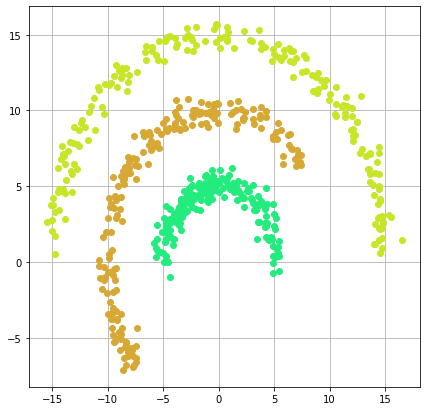

In [118]:
def plot_data(X,labels,colors):
    plt.figure(figsize=(7,7))
    plt.rcParams['axes.axisbelow'] = True
    plt.grid()
    for i, c in enumerate(colors):
        index = np.where(labels==i)[0]
        plt.scatter(X[index,0],X[index,1],c=np.array([c]))

plot_data(X,labels,colors)

## Kernel PCA :

#### Let's choose a kernel :

In [202]:
sigma2 = .1
def gaussian_kernel(sigma2):
    def function(x,y):
        return np.exp(-np.linalg.norm(x-y,ord=2)**2/2/sigma2)
    return function

def laplacian_kernel(sigma):
    def function(x,y):
        return np.exp(-np.linalg.norm(x-y,ord=1)/sigma)
    return function

kernel = gaussian_kernel(sigma2)

## now the kernel matrix K :

K = np.zeros((len(X),len(X)))
for i in range(K.shape[0]):
    for j in range(K.shape[0]):
        K[i,j] = kernel(X[i],X[j])

# kernel PCA algorithm :

In [203]:
## now centering the data in the feature space :

I1n = np.ones(K.shape)/K.shape[0]

Kc = K - np.dot(I1n,K) - np.dot(K,I1n) + np.dot(I1n,np.dot(K,I1n))

## eigendecomposition :

eigvals, eigvecs = np.linalg.eig(Kc)
D = np.diag(eigvals)

# reordering eigenvalues and eigenvectors in decreasing order :
reordering = np.argsort(-eigvals)
D = np.diag(eigvals[reordering])
A = eigvecs.T[reordering].T

## choosing the new dimension $\mathcal{l}$:

In [204]:
l = 10  # new dimension

V = np.zeros((A.shape[0],l))
for k in range(l):
    V[:,k] = A[:,k]/D[k,k]


# calculating projections :
Y = np.zeros((X.shape[0],A.shape[1]))
for i in range(X.shape[0]):
    for s in range(l):
        Y[i,s] = np.dot(V[:,s],Kc[i,:])

## explained variance over dimensions :

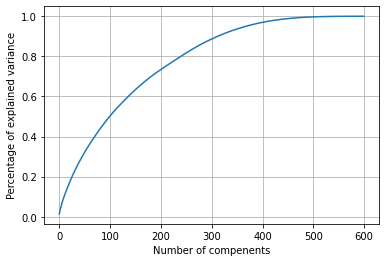

In [205]:
plt.plot(np.cumsum(np.diag(D))/np.sum(D));
plt.grid();
plt.ylabel("Percentage of explained variance")
plt.xlabel("Number of compenents");

## plotting transformed data :

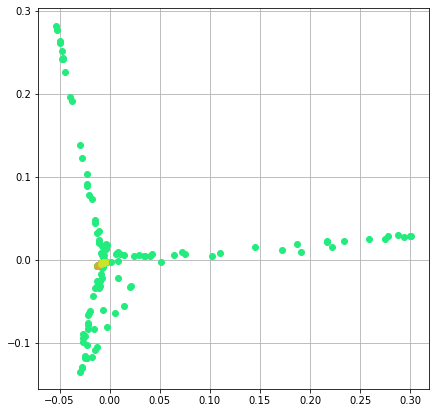

In [206]:
plot_data(Y,labels,colors)

## All of this at one : choosing the best parameters :

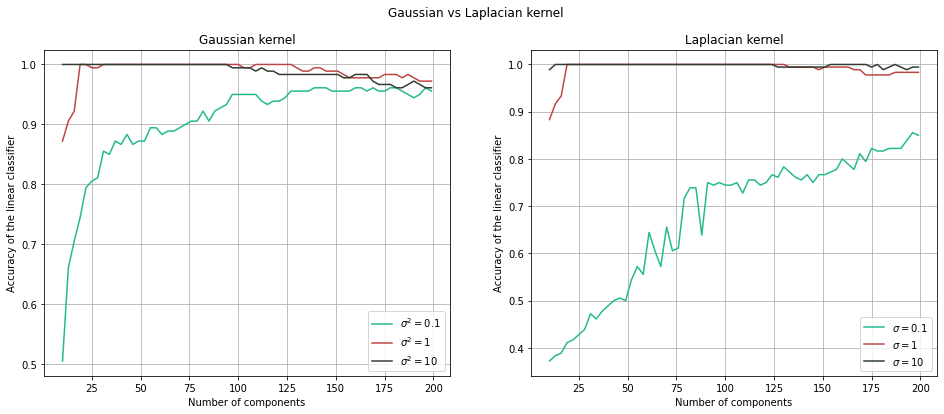

In [220]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

ls = np.arange(10,200,3)
sigma2s = [.1,1,10]
sigmas2colors = np.random.uniform(0,1,(len(sigma2s),3))

plt.figure(figsize=(16,6))
plt.suptitle("Gaussian vs Laplacian kernel")

plt.subplot(1,2,1,title='Gaussian kernel')
for m, sigma2 in enumerate(sigma2s):
    kernel = gaussian_kernel(sigma2)
    K = np.zeros((len(X),len(X)))
    for i in range(K.shape[0]):
        for j in range(K.shape[0]):
            K[i,j] = kernel(X[i],X[j])
    I1n = np.ones(K.shape)/K.shape[0]
    Kc = K - np.dot(I1n,K) - np.dot(K,I1n) + np.dot(I1n,np.dot(K,I1n))
    eigvals, eigvecs = np.linalg.eig(Kc)
    D = np.diag(eigvals)
    reordering = np.argsort(-eigvals)
    D = np.diag(eigvals[reordering])
    A = eigvecs.T[reordering].T
    scores = []
    for l in ls:
        V = np.zeros((A.shape[0],l))
        for k in range(l):
            V[:,k] = np.real(A[:,k]/D[k,k])
        Y = np.zeros((X.shape[0],A.shape[1]))
        for i in range(X.shape[0]):
            for s in range(l):
                Y[i,s] = np.dot(V[:,s],Kc[i,:])
        Ytrain,Ytest,Ztrain,Ztest = train_test_split(Y,labels,shuffle=True,test_size=.3,random_state=42)
        lsvm = LinearSVC(C = 1)
        lsvm.fit(Ytrain,Ztrain)
        scores.append(lsvm.score(Ytest,Ztest))
    plt.plot(ls,scores,linewidth=1.5,c=np.array(sigmas2colors[m]),label='$\sigma^2=$'+str(sigma2))
plt.grid()
plt.legend()
plt.xlabel("Number of components")
plt.ylabel("Accuracy of the linear classifier");
plt.rcParams['axes.axisbelow'] = True

plt.subplot(1,2,2,title='Laplacian kernel')
for m, sigma2 in enumerate(sigma2s):
    kernel = laplacian_kernel(sigma2)
    K = np.zeros((len(X),len(X)))
    for i in range(K.shape[0]):
        for j in range(K.shape[0]):
            K[i,j] = kernel(X[i],X[j])
    I1n = np.ones(K.shape)/K.shape[0]
    Kc = K - np.dot(I1n,K) - np.dot(K,I1n) + np.dot(I1n,np.dot(K,I1n))
    eigvals, eigvecs = np.linalg.eig(Kc)
    D = np.diag(eigvals)
    reordering = np.argsort(-eigvals)
    D = np.diag(eigvals[reordering])
    A = eigvecs.T[reordering].T
    scores = []
    for l in ls:
        V = np.zeros((A.shape[0],l))
        for k in range(l):
            V[:,k] = np.real(A[:,k]/D[k,k])
        Y = np.zeros((X.shape[0],A.shape[1]))
        for i in range(X.shape[0]):
            for s in range(l):
                Y[i,s] = np.dot(V[:,s],Kc[i,:])
        Ytrain,Ytest,Ztrain,Ztest = train_test_split(Y,labels,shuffle=True,test_size=.3,random_state=42)
        lsvm = LinearSVC(C = 1)
        lsvm.fit(Ytrain,Ztrain)
        scores.append(lsvm.score(Ytest,Ztest))
    plt.plot(ls,scores,linewidth=1.5,c=np.array(sigmas2colors[m]),label='$\sigma=$'+str(sigma2))
plt.grid()
plt.legend()
plt.xlabel("Number of components")
plt.ylabel("Accuracy of the linear classifier");
plt.rcParams['axes.axisbelow'] = True

plt.show();